In [1]:
#注意事项:
#当运行本Notebook的程序后，如果要关闭Notebook，请选择菜单: File > Close and Halt 才能确实停止当前正在运行的程序，并且释放资源
#如果没有使用以上方法，只关闭此分页，程序仍在运行，未释放资源，当您打开并运行其他的Notebook，可能会发生错误

In [2]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName('decision tree').setMaster('local[4]')
sc = SparkContext(conf=conf)

In [3]:
sc.master

'local[4]'

# 13.6	如何进行数据准备?

In [4]:
global Path    
if sc.master[0:5]=="local" :
   Path="file:/mnt/data1/workspace/data_analysis_mining/Python+Spark 2.0+Hadoop机器学习与大数据实战/pythonsparkexample/PythonProject/"
else:   
   Path="hdfs://master:9000/user/hduser/"
#如果要在cluster模式运行(hadoop yarn 或Spark Stand alone)，请按照书上的说明，先把文件上传到HDFS目录

In [5]:
print("开始导入数据...")
rawDataWithHeader = sc.textFile(Path+"data/train.tsv")
rawDataWithHeader.take(2)

开始导入数据...


['"url"\t"urlid"\t"boilerplate"\t"alchemy_category"\t"alchemy_category_score"\t"avglinksize"\t"commonlinkratio_1"\t"commonlinkratio_2"\t"commonlinkratio_3"\t"commonlinkratio_4"\t"compression_ratio"\t"embed_ratio"\t"framebased"\t"frameTagRatio"\t"hasDomainLink"\t"html_ratio"\t"image_ratio"\t"is_news"\t"lengthyLinkDomain"\t"linkwordscore"\t"news_front_page"\t"non_markup_alphanum_characters"\t"numberOfLinks"\t"numwords_in_url"\t"parametrizedLinkRatio"\t"spelling_errors_ratio"\t"label"',
 '"http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html"\t"4042"\t"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the S

In [6]:
print("开始导入数据...")
rawDataWithHeader = sc.textFile(Path+"data/train.tsv")
header = rawDataWithHeader.first() 
rawData = rawDataWithHeader.filter(lambda x:x !=header)    
rData=rawData.map(lambda x: x.replace("\"", ""))    
lines = rData.map(lambda x: x.split("\t"))  # 分隔字段
print("共计：" + str(lines.count()) + "项")

开始导入数据...
共计：7395项


In [15]:
columns = header.replace("\"", "").split('\t')
columns

['url',
 'urlid',
 'boilerplate',
 'alchemy_category',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio',
 'label']

In [22]:
lines.first()[4:]  # 都是数值特征字段

['0.789131',
 '2.055555556',
 '0.676470588',
 '0.205882353',
 '0.047058824',
 '0.023529412',
 '0.443783175',
 '0',
 '0',
 '0.09077381',
 '0',
 '0.245831182',
 '0.003883495',
 '1',
 '1',
 '24',
 '0',
 '5424',
 '170',
 '8',
 '0.152941176',
 '0.079129575',
 '0']

In [18]:
# 字段3 alchemy_category 表示分类的字段
# 提取一共有多少种类别的文章, 添加一个数字标签, 返回dict形式
categoriesMap = lines.map(lambda fields: fields[3]).distinct().zipWithIndex().collectAsMap()


In [19]:
categoriesMap  # ? 表示无 数据

{'business': 0,
 'sports': 1,
 '?': 2,
 'arts_entertainment': 3,
 'gaming': 4,
 'culture_politics': 5,
 'computer_internet': 6,
 'law_crime': 7,
 'religion': 8,
 'weather': 9,
 'unknown': 10,
 'recreation': 11,
 'health': 12,
 'science_technology': 13}

In [20]:
len(categoriesMap)

14

In [21]:
type(categoriesMap)

dict

In [23]:
import numpy as np
def extract_features(field,categoriesMap,featureEnd):
    #提取分类特征字段
    categoryIdx = categoriesMap[field[3]] 
    # 转成 one-hot 形式
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1

    #提取数值字段 后面的字段都是数值类型
    numericalFeatures=[convert_float(field) for field in field[4: featureEnd]]    
    #返回“分类特征字段”+“数值特征字段”
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))

In [24]:
def extract_label(field):  # 最后一个字段 表示y
    label=(field[-1])
    return float(label)

In [26]:
labelRDD = lines.map(lambda r: extract_label(r))
print(labelRDD.take(3))

[0.0, 1.0, 1.0]


In [28]:
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map(
    lambda r: LabeledPoint(extract_label(r), extract_features(r, categoriesMap, len(r) -1)))

In [29]:
print(lines.first()[3:])

['business', '0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412', '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1', '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', '0']


In [30]:
labelpointRDD.take(1)

[LabeledPoint(0.0, [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [31]:
labelpointRDD.randomSplit?

Signature: labelpointRDD.randomSplit(weights, seed=None)
Docstring:
Randomly splits this RDD with the provided weights.

:param weights: weights for splits, will be normalized if they don't sum to 1
:param seed: random seed
:return: split RDDs in a list

>>> rdd = sc.parallelize(range(500), 1)
>>> rdd1, rdd2 = rdd.randomSplit([2, 3], 17)
>>> len(rdd1.collect() + rdd2.collect())
500
>>> 150 < rdd1.count() < 250
True
>>> 250 < rdd2.count() < 350
True
File:      /usr/local/spark/python/pyspark/rdd.py
Type:      method


In [32]:
(trainData, validationData, testData) = labelpointRDD.randomSplit([0.8, 0.1, 0.1], seed=0x123)
print("将数据分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))


将数据分trainData:5894   validationData:751   testData:750


In [35]:
def PrepareData(sc): 
    #----------------------1.导入并转换数据-------------
    global Path    
    if sc.master[0:5]=="local" :
       Path="file:/mnt/data1/workspace/data_analysis_mining/Python+Spark 2.0+Hadoop机器学习与大数据实战/pythonsparkexample/PythonProject/"
    else:   
       Path="hdfs://master:9000/user/hduser/"

    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"data/train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")
    #----------2.建立训练评估所需数据 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
                 extract_label(r), 
                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1)))
        
    #-----------3.以随机方式将数据分为3个部分并且返回-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("将数据分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #返回数据


In [36]:
(trainData, validationData, testData, categoriesMap) =PrepareData(sc)

开始导入数据...
共计：7395项
将数据分trainData:5937   validationData:732   testData:726


In [37]:
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[42] at RDD at PythonRDD.scala:53

# 13.7	如何训练模型?

In [38]:
from pyspark.mllib.tree import DecisionTree
model = DecisionTree.trainClassifier(
    trainData, numClasses=2,
    categoricalFeaturesInfo={}, 
    impurity="entropy", maxDepth=5, maxBins=5
    )  # 每个节点最大分支数5, 最大深度5

# 13.8	如何使用模型进行预测?

In [39]:
def PredictData(sc,model,categoriesMap): 
    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"data/test.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")

    dataRDD = lines.map(lambda r: (r[0],
                         extract_features(r, categoriesMap, len(r))))
    DescDict = {
           0: "暂时性网页(ephemeral)",
           1: "长青网页(evergreen)"}
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print(f"网址:{data[0]}\n ===>预测:{predictResult} 说明是: {DescDict[predictResult]}")

    

In [40]:
print("==========预测数据===============")
PredictData(sc, model, categoriesMap)

==========预测数据===============
开始导入数据...
共计：3171项
网址:http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
 ===>预测:1.0 说明是: 长青网页(evergreen)
网址:http://lolpics.se/18552-stun-grenade-ar
 ===>预测:0.0 说明是: 暂时性网页(ephemeral)
网址:http://www.xcelerationfitness.com/treadmills.html
 ===>预测:0.0 说明是: 暂时性网页(ephemeral)
网址:http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
 ===>预测:0.0 说明是: 暂时性网页(ephemeral)
网址:http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
 ===>预测:0.0 说明是: 暂时性网页(ephemeral)
网址:http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
 ===>预测:0.0 说明是: 暂时性网页(ephemeral)
网址:http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
 ===>预测:1.0 说明是: 长青网页(evergreen)
网址:http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-with-lemon-sage-brown-butter-sauce/
 ===>预测:1.0 说明是: 长青网页(evergreen)
网址:http://www.funniez.net/F

# 13.9	如何评估模型的准确率?

In [41]:
y_pred = model.predict(validationData.map(lambda lp: lp.features))
y_pred_true = y_pred.zip(validationData.map(lambda lp: lp.label))
y_pred_true.take(10)

[(0.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 1.0),
 (1.0, 1.0),
 (0.0, 1.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 1.0)]

In [42]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

metrics = BinaryClassificationMetrics(y_pred_true)

print(f"AUC : {metrics.areaUnderROC}")

AUC : 0.6296716756789055


In [44]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [45]:
AUC=evaluateModel(model, validationData)
print("AUC="+str(AUC))

AUC=0.6296716756789055


In [56]:
from time import time
# 改变不同参数 查看结果
def trainEvaluateModel(trainData,validationData,
                      impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print(f"训练评估：使用参数 impurity={impurityParm}, maxDepth={maxDepthParm}, maxBins={maxBinsParm},==>所需时间={duration} 结果AUC = {AUC}")
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

In [57]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)

训练评估：使用参数 impurity=entropy, maxDepth=5, maxBins=5,==>所需时间=1.0394065380096436 结果AUC = 0.6296716756789055


In [58]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)

训练评估：使用参数 impurity=entropy, maxDepth=5, maxBins=5,==>所需时间=0.9168531894683838 结果AUC = 0.6284444444444446


# 13.10	模型的训练参数如何影响准确率?

In [59]:
impurityList=["gini", "entropy"]
maxDepthList =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=10,==>所需时间=1.485440731048584 结果AUC = 0.6352806739760404
训练评估：使用参数 impurity=entropy, maxDepth=10, maxBins=10,==>所需时间=1.2150847911834717 结果AUC = 0.6312102291399038


In [60]:
metrics

[(0.6352806739760404,
  1.485440731048584,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 605 nodes),
 (0.6312102291399038,
  1.2150847911834717,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 511 nodes)]

In [61]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.635281,1.485441,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.631210,1.215085,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


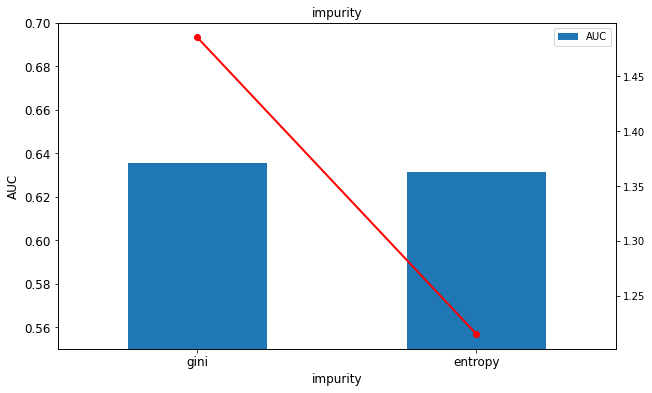

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline 
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.55,0.7])
ax.set_ylabel("AUC",fontsize=12)
# ax2 = ax.twinx()
# ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')secondary_y=True
df['duration'].plot(linestyle='-', marker='o', linewidth=2.0,color='r',  secondary_y=True)
plt.show()

In [65]:
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()

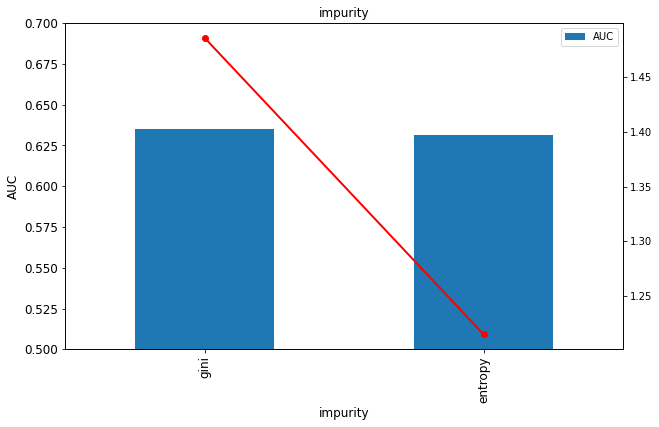

In [66]:
showchart(df,'impurity','AUC','duration',0.5,0.7 )

In [67]:
#定义evalParameter函数
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #训练评估参数
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #设置当前评估的参数
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #转换为Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #显示图形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )
    

训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=10,==>所需时间=1.6189320087432861 结果AUC = 0.6352806739760404
训练评估：使用参数 impurity=entropy, maxDepth=10, maxBins=10,==>所需时间=1.0734450817108154 结果AUC = 0.6312102291399038


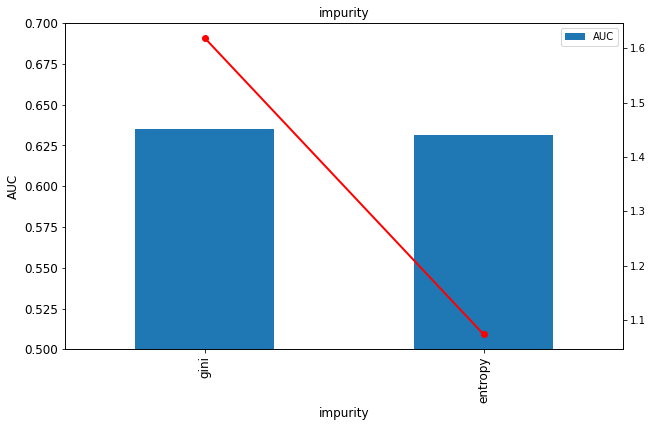

In [68]:
evalParameter(trainData, validationData,"impurity", 
                              impurityList=["gini", "entropy"],   
                              maxDepthList=[10],  
                              maxBinsList=[10 ])  

训练评估：使用参数 impurity=gini, maxDepth=3, maxBins=10,==>所需时间=0.7616021633148193 结果AUC = 0.589594598631733
训练评估：使用参数 impurity=gini, maxDepth=5, maxBins=10,==>所需时间=0.7133686542510986 结果AUC = 0.6279762793893585
训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=10,==>所需时间=0.7862298488616943 结果AUC = 0.6352806739760404
训练评估：使用参数 impurity=gini, maxDepth=15, maxBins=10,==>所需时间=0.9702386856079102 结果AUC = 0.6071684641352731
训练评估：使用参数 impurity=gini, maxDepth=20, maxBins=10,==>所需时间=1.3695337772369385 结果AUC = 0.614450452603591
训练评估：使用参数 impurity=gini, maxDepth=25, maxBins=10,==>所需时间=1.4766745567321777 结果AUC = 0.6077659606249813


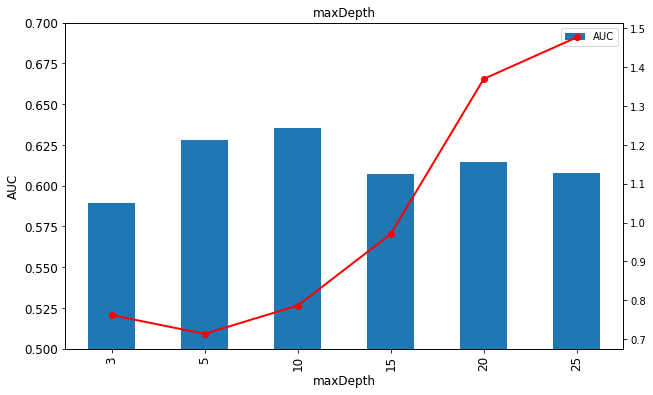

In [69]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=3,==>所需时间=0.7026510238647461 结果AUC = 0.5959728736593672
训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=5,==>所需时间=1.0486717224121094 结果AUC = 0.6333462790906104
训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=10,==>所需时间=0.7390663623809814 结果AUC = 0.6352806739760404
训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=50,==>所需时间=1.040241003036499 结果AUC = 0.653437098557046
训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=100,==>所需时间=0.7846360206604004 结果AUC = 0.6362366683595735
训练评估：使用参数 impurity=gini, maxDepth=10, maxBins=200,==>所需时间=1.2011737823486328 结果AUC = 0.6270202850058256


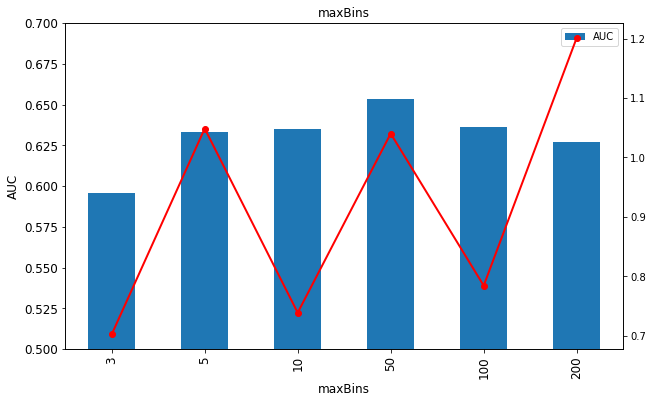

In [70]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

# 13.11	如何找出准确率最高的参数组合?

In [71]:
#定义evalAllParameter函数
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for循环训练评估所有参数组合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的参数组合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #显示调校后最佳参数组合      
    print("调校后最佳参数：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    结果AUC = " + str(bestParameter[0]))
    #返回最佳模型
    return bestParameter[5]

In [72]:
    print("-----所有参数训练评估找出最好的参数组合---------")  
    bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15, 20, 25], 
                          [3, 5, 10, 50, 100, 200 ])

-----所有参数训练评估找出最好的参数组合---------
训练评估：使用参数 impurity=gini, maxDepth=3, maxBins=3,==>所需时间=0.9223558902740479 结果AUC = 0.5843665043467869
训练评估：使用参数 impurity=gini, maxDepth=3, maxBins=5,==>所需时间=0.7394404411315918 结果AUC = 0.5925447375496669
训练评估：使用参数 impurity=gini, maxDepth=3, maxBins=10,==>所需时间=0.4445819854736328 结果AUC = 0.589594598631733
训练评估：使用参数 impurity=gini, maxDepth=3, maxBins=50,==>所需时间=0.5681006908416748 结果AUC = 0.5919098975293521
训练评估：使用参数 impurity=gini, maxDepth=3, maxBins=100,==>所需时间=0.5790321826934814 结果AUC = 0.594523944671825
训练评估：使用参数 impurity=gini, maxDepth=3, maxBins=200,==>所需时间=0.49643564224243164 结果AUC = 0.5918501478803811
训练评估：使用参数 impurity=gini, maxDepth=5, maxBins=3,==>所需时间=0.7084054946899414 结果AUC = 0.5864801481791294
训练评估：使用参数 impurity=gini, maxDepth=5, maxBins=5,==>所需时间=0.7605900764465332 结果AUC = 0.6279762793893585
训练评估：使用参数 impurity=gini, maxDepth=5, maxBins=10,==>所需时间=0.675325870513916 结果AUC = 0.6279762793893585
训练评估：使用参数 impurity=gini, maxDepth=5, maxBins=50,==>所需时

# 13.12 如何确认是否Overfitting（过度训练）？

In [74]:
AUC=evaluateModel(model, testData)
print("AUC="+str(AUC))

AUC=0.6284444444444446
